# Fine-tunning with transformers API including Quantization

**Quantization**

Техниките за quantization (квантуване) намаляват разходите за памет и изчисления чрез представяне на тегла и активации с типове данни с по-ниска точност като 8-битови цели числа (int8). Това позволява зареждане на по-големи модели, които обикновено не бихте могли да поберете в паметта, и ускоряване на изводите. Transformers поддържа алгоритмите за quantization **AWQ*** и **GPTQ*** и поддържа 8-битово и 4-битово quantization с bitsandbytes.

(AWQ (Activation-aware Weight Quantization) → Оптимизирана квантова компресия, запазва точността чрез адаптиране към активациите.
GPTQ (Gaussian Process Tensor Quantization) → Бърза пост-квантова компресия, намалява размера на LLM без значителна загуба на качество.)

Техниките за quantization, които не се поддържат в **Transformers**, могат да бъдат добавени с класа `HfQuantizer`.

-----------

Тези техники се фокусират върху представянето на данни с по-малко информация, като същевременно се опитват да не загубят твърде много точност. Това често означава преобразуване на тип данни за представяне на същата информация с по-малко битове. Например, ако теглата на модела ви се съхраняват като 32-битови плаващи точки и са quantized до 16-битови плаващи точки, това намалява наполовина размера на модела, което го прави по-лесен за съхранение и намалява използването на паметта. По-ниската прецизност може също да ускори изводите, защото отнема по-малко време за извършване на изчисления с по-малко битове.


Библиотеката Transformers на HuggingFace е предпочитан избор за работа с предварително обучени езикови модели. За да направи процеса на quantization на модела по-достъпен, HuggingFace се интегрира безпроблемно с библиотеката Bitsandbytes. Тази интеграция опростява процеса на quantization и дава възможност на потребителите да постигнат ефективни модели само с няколко реда код.

# HfQuantizer

`(quantization_config: QuantizationConfigMixin**kwargs)`

Абстрактен клас на quantization HuggingFace. Поддържа quantization на модели на HF трансформери за извод и/или quantization. Този клас се използва само за `transformers.PreTrainedModel.from_pretrained` и все още не може лесно да се използва извън обхвата на този метод.

Атрибути `quantization_config(transformers.utils.quantization_config.QuantizationConfigMixin)`: Конфигурацията за quantization, която дефинира параметрите за квантуване на модела, който искаме. `modules_to_not_convert (List[str], по избор)`: Списъкът с имена на модули, които да не се преобразуват при quantization на модела. `required_packages (List[str], по избор)`: Списъкът с необходимите `pip` пакети за инсталиране преди използване на quantizator `requires_calibration (bool)`: Дали методът на квантуване изисква калибриране на модела, преди да го използвате. `requires_parameters_quantization (bool)`: Дали методът за квантуване изисква създаване на нов параметър. Например, за bitsandbytes е необходимо да се създаде нов xxxParameter.

Install latest accelerate from source:

In [ ]:
# DO NOT RUN
pip install git+https://github.com/huggingface/accelerate.git

Install latest transformers from source and bitsandbytes:

In [ ]:
# DO NOT RUN
pip install git+https://github.com/huggingface/transformers.git

pip install bitsandbytes

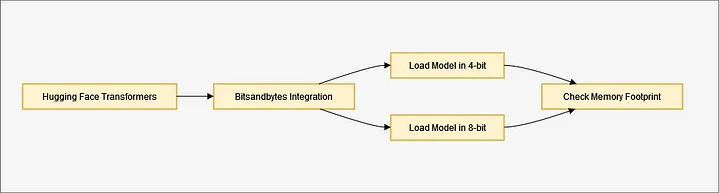

                        HuggingFace and Bitsandbytes Integration Uses.

# Зареждане на модел в 4-битово quantization

Една от ключовите характеристики на тази интеграция е възможността за зареждане на модели в 4-бита. Това може да стане чрез задаване на аргумента **load_in_4bit=True** при извикване на метода **.from_pretrained**. По този начин може да се намали използването на паметта приблизително четири пъти.

In [1]:
!pip install torch # Библиотека за машинно обучение, използвана за разработка на невронни мрежи и deep learning
!pip install transformers # Лесно използване на предварително обучени езикови модели като GPT, BERT, LLaMA
!pip install bitsandbytes # квантуване на модели, позволяваща използване на 8-битови и 4-битови тежести
!pip install accelerate # улесняване на разпределеното обучение и използването на модели върху различни хардуерни среди (GPU, CPU, TPU)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from huggingface_hub import notebook_login

notebook_login() # hf_API_KEY

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "bigscience/bloom-1b7" # Научен многоезичен езиков модел

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", load_in_4bit=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Зареждане на модел в 8-битово quantization

За допълнителна оптимизация на паметта можете да се зареди модел в 8-бита. Това може да се постигне чрез използване на аргумента **load_in_8bit=True** при извикване на **.from_pretrained**. Това намалява отпечатъка от паметта приблизително наполовина.

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "bigscience/bloom-1b7"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Може дори да се провери отпечатъка на паметта на модела, като се използва метода **get_memory_footprint**:

In [5]:
print(model.get_memory_footprint())

2236858368


### Код без квантуване:

In [6]:
!pip install transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Using a larger model without quantization
model_id = "meta-llama/Llama-3.1-8B-Instruct"

# Load
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    load_in_8bit=False,  # Not using 8-bit or 4-bit quantization
)

inputs = tokenizer("Hello, how are you?", return_tensors="pt") #.to("cuda")

# Model inference
outputs = model.generate(**inputs, max_length=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:2347: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Output you shoud see: *Your session crashed after using all available RAM.*